<a href="https://colab.research.google.com/github/victor-roris/mediumseries/blob/master/NLP/ModelInterpretability_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations 

XGBoost, LightGBM, CatBoost, Pyspark and most tree-based scikit-learn models are supported.

GITHUB: https://github.com/slundberg/shap

DOCUMENTATION: https://shap.readthedocs.io/en/latest/

ADAPTED FROM: https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b

## INSTALLATION

In [0]:
pip install shap

## EXAMPLE OF USAGE

In [0]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import shap

### GENERATE MODEL

* **Fetch data**

In [4]:
df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df.head()

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


Clean the data

In [5]:
# Remove entries with null tags 
df = df[pd.notnull(df['tags'])]

# Get a fraction of the entries
df = df.sample(frac=0.5, random_state=99).reset_index(drop=True)

# Randomize the values
df = shuffle(df, random_state=22)
df = df.reset_index(drop=True)

# Create a label column from the tags column
df['class_label'] = df['tags'].factorize()[0]

print(f'Number of labelled examples : {len(df)}')
df.head()

Number of labelled examples : 20000


,post,tags,class_label
0,how do i move something in rails i m a progr...,ruby-on-rails,0
1,c# how to output specific array searches t...,c#,1
2,integer.parseint and string format with decima...,java,2
3,compilation problem while upgrading a website ...,.net,3
4,query to list out the records by comparing max...,sql,4


* **Prepare data**

  - *Labels*

Binarize the labels

In [6]:
tags_split = [tags.split(',') for tags in df['tags'].values]
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)

print(f'Labels by entry in a binary matrix of = ({tags_encoded.shape[0]} examples) X ({tags_encoded.shape[1]} labels)')
tags_encoded

Labels by entry in a binary matrix of = (20000 examples) X (20 labels)


array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
print(f'Classe labels: {tag_encoder.classes_}')

Classe labels: ['.net' 'android' 'angularjs' 'asp.net' 'c' 'c#' 'c++' 'css' 'html' 'ios'
 'iphone' 'java' 'javascript' 'jquery' 'mysql' 'objective-c' 'php'
 'python' 'ruby-on-rails' 'sql']


Get the binary labels matrix for the training and evaluation datasets

In [8]:
num_tags = len(tags_encoded[0])
train_size = int(len(df)*0.8)

print(f'Number of labels : {num_tags}')
print(f'Number of examples in the training dataset : {train_size}')

Number of labels : 20
Number of examples in the training dataset : 16000


In [9]:
y_train = tags_encoded[: train_size]
y_test = tags_encoded[train_size:]

print(f'Binarize Label for each training example - binary matrix of = ({y_train.shape[0]} training examples) X ({y_train.shape[1]} labels)')
print(f'Binarize Label for each evaluation example - binary matrix of = ({y_test.shape[0]} training examples) X ({y_test.shape[1]} labels)')

Binarize Label for each training example - binary matrix of = (16000 training examples) X (20 labels)
Binarize Label for each evaluation example - binary matrix of = (4000 training examples) X (20 labels)


 - *Text*

In [10]:
train_post = df['post'].values[:train_size]
test_post = df['post'].values[train_size:]

print(f'Number of training texts : {len(train_post)}')
print(f'Number of evaluation texts : {len(test_post)}')

Number of training texts : 16000
Number of evaluation texts : 4000


Tokenize the texts

In [0]:
class TextPreprocessor(object):
    # Class to contain text processor functionalities
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix

In [0]:
# Instiate the Text Processor
VOCAB_SIZE = 500
processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_post)

In [0]:
# Get the tokenized version of the training and evaluation texts 
X_train = processor.transform_text(train_post)
X_test = processor.transform_text(test_post)

In [14]:
print(f'Training data expresed in a matrix of tokens of: ({X_train.shape[0]} examples) x ({X_train.shape[1]} tokens) ')
X_train

Training data expresed in a matrix of tokens of: (16000 examples) x (500 tokens) 


array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [15]:
print(f'Training data expresed in a matrix of tokens of: ({X_test.shape[0]} examples) x ({X_test.shape[1]} tokens) ')
X_test

Training data expresed in a matrix of tokens of: (4000 examples) x (500 tokens) 


array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

* **Train model**

In [16]:
def create_model(vocab_size, num_tags):
    # Create a keras sequential model

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(50, input_shape = (vocab_size,), activation='relu'))
    model.add(tf.keras.layers.Dense(25, activation='relu'))
    model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model
    
# Create model
model = create_model(VOCAB_SIZE, num_tags)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
# Train model
model.fit(X_train, y_train, epochs = 2, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(model.evaluate(X_test, y_test, batch_size = 128)))

Train on 14400 samples, validate on 1600 samples
Epoch 1/2
14400/14400 [==============================] - 1s 35us/sample - loss: 0.2792 - acc: 0.9165 - val_loss: 0.1864 - val_acc: 0.9501
Epoch 2/2
4000/4000 [==============================] - 0s 11us/sample - loss: 0.1325 - acc: 0.9564
Eval loss/accuracy:[0.1324819493293762, 0.95644987]


### EXPLAINING PREDICTIONS USING SHAP

We use the first X training documents as our background data set to integrate over, and to create a SHAP explainer object.

In [18]:
attrib_data = X_train[:400]
explainer = shap.DeepExplainer(model, attrib_data)

We get the attribution values for individual predictions on a subset of the test set.

In [0]:
eval_data = X_test[:40]
shap_vals = explainer.shap_values(eval_data)

We get the feature names. In the NLP model the features are the words in the vocabulary. 

In [20]:
words = processor._tokenizer.word_index
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)
word_lookup = [''] + word_lookup

print(f'Features size : {len(word_lookup)}')
print(f'List of words in the vocabulary: {word_lookup[0:20]} ...')

Features size : 79055
List of words in the vocabulary: ['', 'the', 'i', 'code', 'lt', 'gt', 'to', 'a', 'pre', 'in', 'is', 'and', 'this', 'of', '0', 'it', '1', 'for', 'if', 'id'] ...


Use SHAP’s `summary_plot` method to show the top features impacting model predictions.

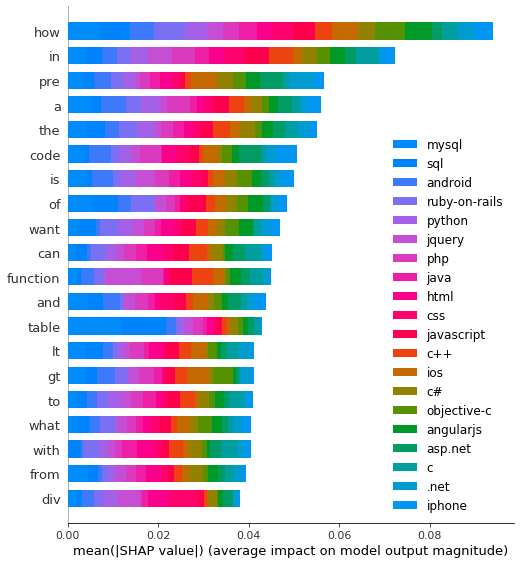

In [21]:
shap.summary_plot(
    # Explicability values
    shap_vals, 
    
    #Names for each feature
    feature_names=word_lookup, 

    #Names of the label classes
    class_names=tag_encoder.classes_)

* Each row is a signal word that contribute in the model.
* Longest rows are biggest signals used by the model. In the plot the signal words are represented in order of importance in the model. The first signal word in the plot (in this case 'how') is the biggest signal word used by the model. The second is the second, third ...
* Each color represent the contribution of the signal word to a specific category. In this case, the color in the word 'in' is bigger in `javascript` than in `python`. In this case, 'in' contribute more to `javascript` than to `python` predictions. 